# AA1 - Support2: Predicting deaths for critically ill patients

## 1. Loading the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import seaborn as sns

# Modelling
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score, roc_curve, auc

In [2]:
support = pd.read_csv("support2.csv")
support.head()

,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,...,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,11.0,...,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,NaN,7.0
2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,...,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,<2 mo. follow-up,1.0
3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,...,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0,<2 mo. follow-up,0.0
4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,11.0,...,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0,no(M2 and SIP pres),0.0
5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,...,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0,no(M2 and SIP pres),2.0


From the dataset documentation, we are told not not use the following variables for any predictions, since they are only useful when using findings from previous models, thus, we drop them.

In [3]:
support.drop(["aps", "sps", "surv2m", "surv6m", "prg2m", "prg6m", "dnr", "dnrday"], axis=1, inplace=True)
support.shape

(9105, 39)

In [4]:
support.describe()

,age,death,hospdead,slos,d.time,num.co,edu,scoma,charges,totcst,...,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
count,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,7471.000000,9104.000000,8.933000e+03,8217.000000,...,6504.000000,9038.000000,9104.000000,6821.000000,4605.000000,4753.000000,4243.000000,3464.000000,6238.000000,9105.000000
mean,62.650823,0.681054,0.259198,17.863042,478.449863,1.868644,11.747691,12.058546,5.999579e+04,30825.867768,...,2.554463,1.770961,137.568541,7.415364,159.873398,32.349463,2191.546047,1.157910,1.637384,1.888272
std,15.593710,0.466094,0.438219,22.006440,560.383272,1.344409,3.447743,24.636694,1.026488e+05,45780.820986,...,5.318448,1.686041,6.029326,0.080563,88.391541,26.792288,1455.245777,1.739672,2.231358,2.003763
min,18.041990,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,1.169000e+03,0.000000,...,0.099991,0.099991,110.000000,6.829102,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,52.797000,0.000000,0.000000,6.000000,26.000000,1.000000,10.000000,0.000000,9.740000e+03,5929.566400,...,0.500000,0.899902,134.000000,7.379883,103.000000,14.000000,1165.500000,0.000000,0.000000,0.000000
50%,64.856990,1.000000,0.000000,11.000000,233.000000,2.000000,12.000000,0.000000,2.502400e+04,14452.734400,...,0.899902,1.199951,137.000000,7.419922,135.000000,23.000000,1968.000000,0.000000,1.000000,1.000000
75%,73.998960,1.000000,1.000000,20.000000,761.000000,3.000000,14.000000,9.000000,6.459800e+04,36087.937500,...,1.899902,1.899902,141.000000,7.469727,188.000000,42.000000,3000.000000,2.000000,3.000000,3.000000
max,101.847960,1.000000,1.000000,343.000000,2029.000000,9.000000,31.000000,100.000000,1.435423e+06,633212.000000,...,63.000000,21.500000,181.000000,7.769531,1092.000000,300.000000,9000.000000,7.000000,7.000000,7.073242


In [5]:
support.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9105 entries, 1 to 9105
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       9105 non-null   float64
 1   death     9105 non-null   int64  
 2   sex       9105 non-null   object 
 3   hospdead  9105 non-null   int64  
 4   slos      9105 non-null   int64  
 5   d.time    9105 non-null   int64  
 6   dzgroup   9105 non-null   object 
 7   dzclass   9105 non-null   object 
 8   num.co    9105 non-null   int64  
 9   edu       7471 non-null   float64
 10  income    6123 non-null   object 
 11  scoma     9104 non-null   float64
 12  charges   8933 non-null   float64
 13  totcst    8217 non-null   float64
 14  totmcst   5630 non-null   float64
 15  avtisst   9023 non-null   float64
 16  race      9063 non-null   object 
 17  hday      9105 non-null   int64  
 18  diabetes  9105 non-null   int64  
 19  dementia  9105 non-null   int64  
 20  ca        9105 non-null   object 
 

In [6]:
percent_missing = support.isnull().mean() * 100
percent_missing

age          0.000000
death        0.000000
sex          0.000000
hospdead     0.000000
slos         0.000000
d.time       0.000000
dzgroup      0.000000
dzclass      0.000000
num.co       0.000000
edu         17.946183
income      32.751236
scoma        0.010983
charges      1.889072
totcst       9.752883
totmcst     38.165843
avtisst      0.900604
race         0.461285
hday         0.000000
diabetes     0.000000
dementia     0.000000
ca           0.000000
meanbp       0.010983
wblc         2.328391
hrt          0.010983
resp         0.010983
temp         0.010983
pafi        25.535420
alb         37.034596
bili        28.566722
crea         0.735859
sod          0.010983
ph          25.085118
glucose     49.423394
bun         47.797913
urine       53.399231
adlp        61.954970
adls        31.488193
sfdm2       15.376167
adlsc        0.000000
dtype: float64

Since the dataset has many features, we reduce it the by removing the features that contain a high number of missing values. 

In [7]:
support.drop(percent_missing[percent_missing > 5].index, axis=1, inplace=True)

Features death and hospdead both indicate the death of the patient at different time periods, either during in hospital or after a two-week period after leaving hospital. Since we are going to be interested in predicting death in general, we will use the death feature.

In [8]:
support.drop("hospdead", axis=1, inplace=True)

For the sake of simplicity, we renamed some features with more explanatory names to make it easier to work with.

In [9]:
support.rename(columns={
    'num.co': 'simul_diseases',
    'd.time' : 'days_followup',
    'slos' : "days_study",
    'hday' : "days_befstudy"}, inplace=True)

In [10]:
support.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9105 entries, 1 to 9105
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             9105 non-null   float64
 1   death           9105 non-null   int64  
 2   sex             9105 non-null   object 
 3   days_study      9105 non-null   int64  
 4   days_followup   9105 non-null   int64  
 5   dzgroup         9105 non-null   object 
 6   dzclass         9105 non-null   object 
 7   simul_diseases  9105 non-null   int64  
 8   scoma           9104 non-null   float64
 9   charges         8933 non-null   float64
 10  avtisst         9023 non-null   float64
 11  race            9063 non-null   object 
 12  days_befstudy   9105 non-null   int64  
 13  diabetes        9105 non-null   int64  
 14  dementia        9105 non-null   int64  
 15  ca              9105 non-null   object 
 16  meanbp          9104 non-null   float64
 17  wblc            8893 non-null   float6

## 2. Preprocessing

### 2.1 Basic inspection of the dataset

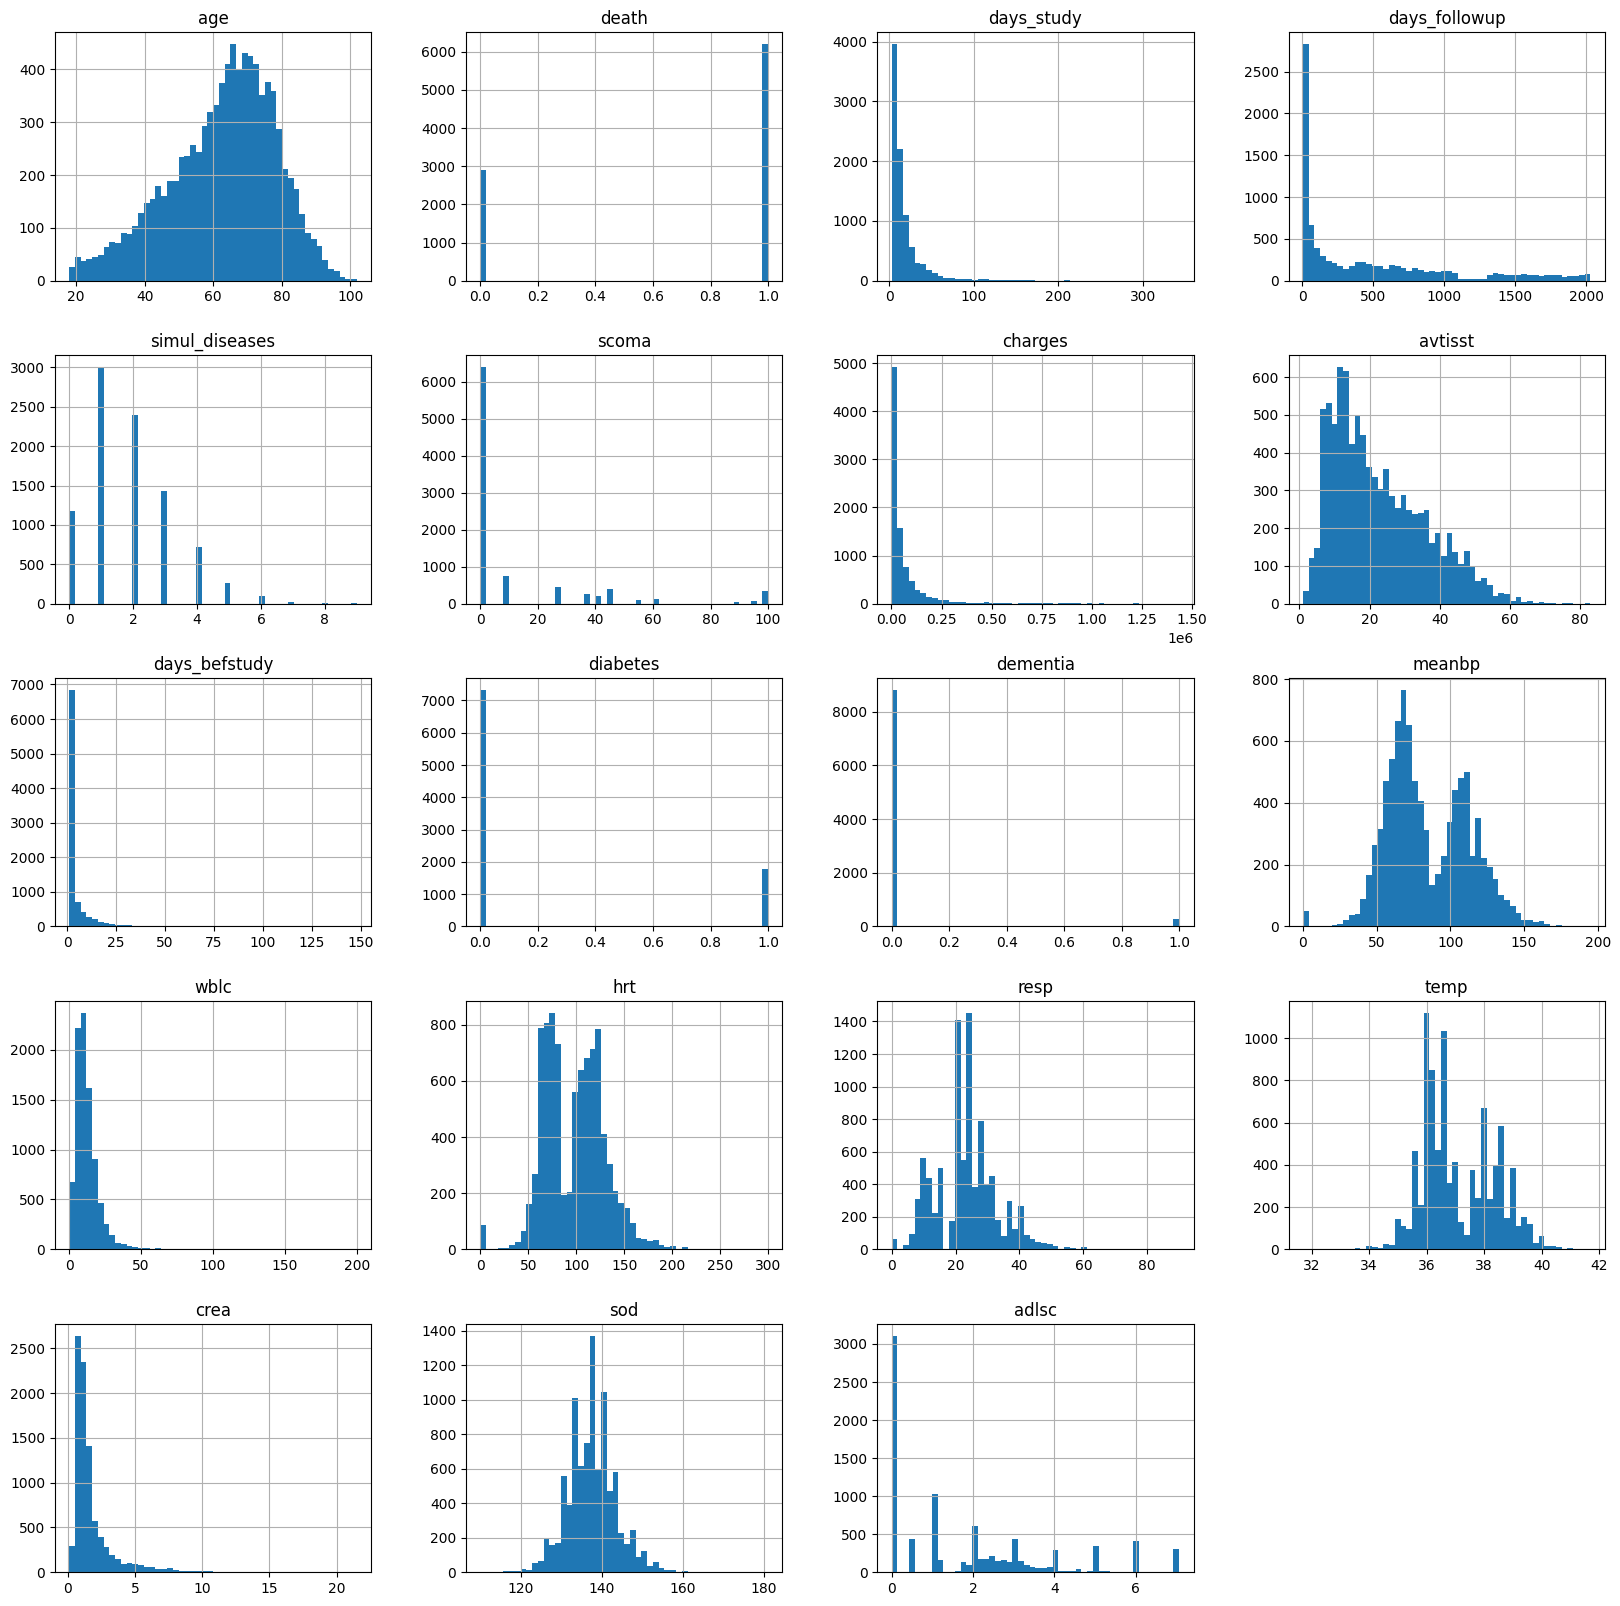

In [11]:
support.hist(bins=50, figsize=(20, 20))
plt.show()

We can see how we might have presence of outliers or need to correct for Gaussianity. Moreover, we can see a clear imbalance for our target feature death. 

In [12]:
for col in support.columns:
    print(f"Column: {col}")
    print(support[col].value_counts())
    print()

Column: age
age
71.99695    5
52.98599    4
75.87695    4
52.38599    4
66.14600    4
           ..
57.92499    1
90.75995    1
66.32196    1
89.72998    1
81.53894    1
Name: count, Length: 7323, dtype: int64

Column: death
death
1    6201
0    2904
Name: count, dtype: int64

Column: sex
sex
male      5125
female    3980
Name: count, dtype: int64

Column: days_study
days_study
5      688
4      656
7      643
6      632
9      500
      ... 
140      1
104      1
339      1
223      1
189      1
Name: count, Length: 167, dtype: int64

Column: days_followup
days_followup
4      238
5      194
7      180
6      155
8      144
      ... 
600      1
682      1
768      1
771      1
184      1
Name: count, Length: 1724, dtype: int64

Column: dzgroup
dzgroup
ARF/MOSF w/Sepsis    3515
CHF                  1387
COPD                  967
Lung Cancer           908
MOSF w/Malig          712
Coma                  596
Colon Cancer          512
Cirrhosis             508
Name: count, dtype: int64

C

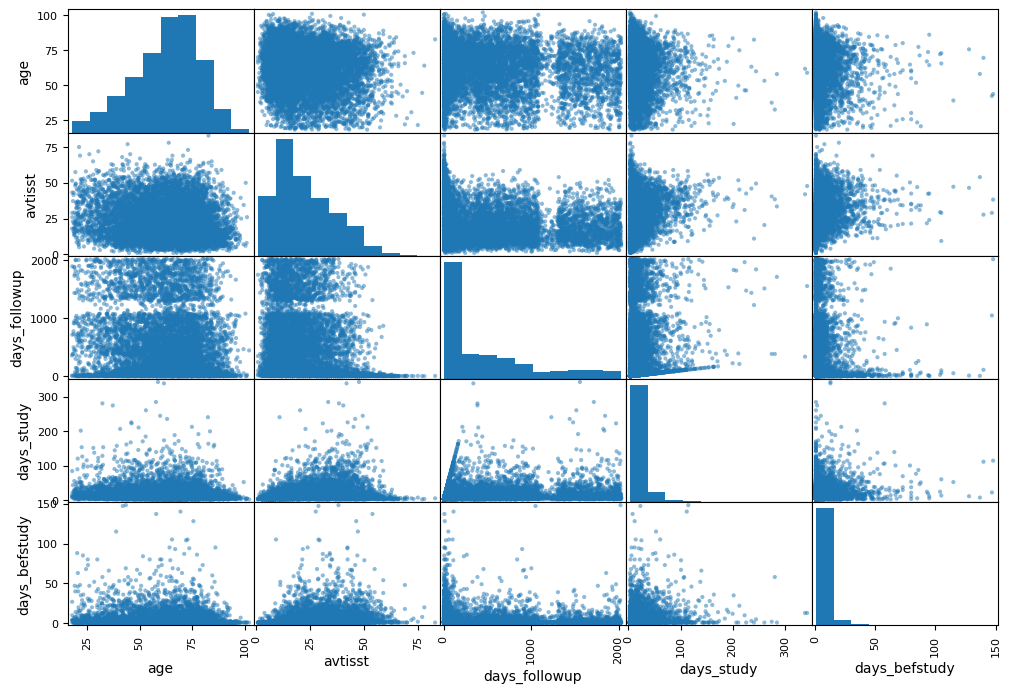

In [13]:
scatter_matrix(support[["age", "avtisst", "days_followup", "days_study", "days_befstudy"]], figsize=(12, 8))
plt.show()

Most of the features seem to be uncorrelated

For the preprocessing needed, we need to fill out those NaN values, remove possible outliers, perform some feature engineering, encode the categorical features, correct for Gaussianity and finally scale our data.

### 2.2 Train/Test split

To prevent any data leakage while doing out transformations, we split the data for testing our model in the future.

In [14]:
(support.isnull().sum(axis=1) >= 2).sum()

51

In [15]:
support = support[support.isnull().sum(axis=1) < 2]
X = support.drop("death", axis=1)
y = support["death"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
X_train

,age,sex,days_study,days_followup,dzgroup,dzclass,simul_diseases,scoma,charges,avtisst,...,dementia,ca,meanbp,wblc,hrt,resp,temp,crea,sod,adlsc
8660,66.35498,male,63,866,ARF/MOSF w/Sepsis,ARF/MOSF,2,0.0,116735.000,38.50,...,0,no,61.0,5.599609,107.0,16.0,35.69531,1.199951,134.0,5.000000
6892,33.19897,male,8,984,ARF/MOSF w/Sepsis,ARF/MOSF,4,0.0,12548.000,16.50,...,0,no,128.0,19.000000,116.0,40.0,37.69531,0.599976,142.0,4.000000
5319,26.10799,female,19,19,MOSF w/Malig,ARF/MOSF,1,0.0,NaN,16.00,...,0,metastatic,155.0,9.298828,50.0,26.0,35.50000,1.799805,147.0,2.739258
3281,39.31000,male,11,11,ARF/MOSF w/Sepsis,ARF/MOSF,3,0.0,32710.188,17.50,...,0,no,94.0,21.699219,120.0,24.0,37.29688,1.899902,132.0,3.000000
8347,64.93097,female,43,1393,ARF/MOSF w/Sepsis,ARF/MOSF,3,0.0,85693.000,35.75,...,0,no,74.0,24.296875,125.0,42.0,38.09375,0.799927,141.0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538,62.86398,male,5,957,CHF,COPD/CHF/Cirrhosis,4,0.0,NaN,7.00,...,0,no,0.0,7.199219,0.0,10.0,36.09375,1.099854,139.0,0.000000
7226,45.42099,male,15,717,CHF,COPD/CHF/Cirrhosis,2,0.0,27278.000,18.00,...,0,no,72.0,22.199219,121.0,10.0,36.00000,2.899902,130.0,0.000000
5381,69.65094,female,28,265,ARF/MOSF w/Sepsis,ARF/MOSF,4,44.0,43552.000,15.75,...,1,yes,55.0,10.298828,160.0,10.0,38.00000,6.799805,135.0,7.000000
2494,79.49896,female,5,83,Colon Cancer,Cancer,2,0.0,6147.000,9.00,...,0,metastatic,77.0,6.899414,80.0,20.0,37.00000,0.899902,135.0,2.431152


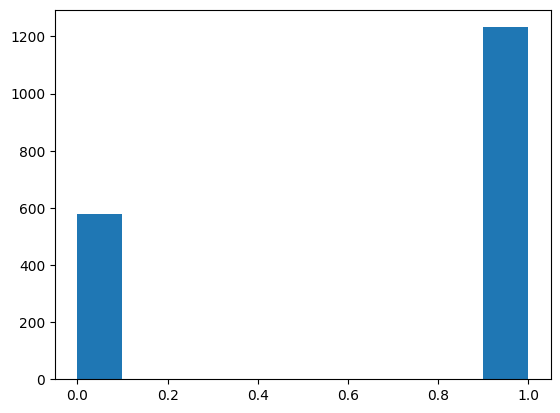

In [17]:
plt.hist(y_test)
plt.show()

### 2.3 NaN values cleaning

<Axes: >

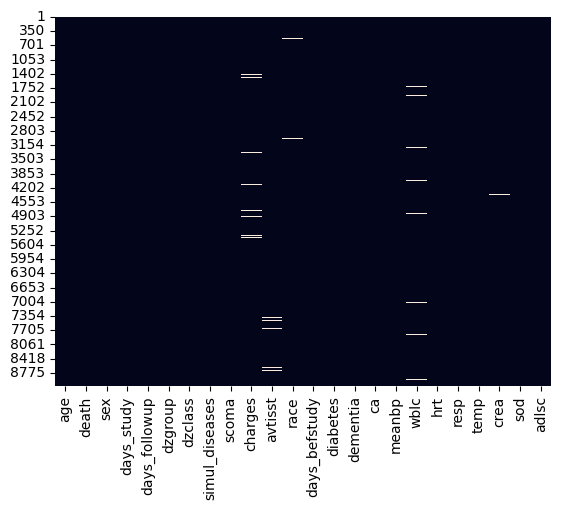

In [18]:
sns.heatmap(support.isnull(), cbar=False)

We create a custom transformer that fits instances without NaN values of the training set and we use it to impute the NaN values of both train and test set.

In [19]:
class KNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target, categorical):
        self.target = target
        self.categorical = categorical

    def transform(self, X):
        missing_target = X[X[self.target].isna()]

        missing_target_predictors = missing_target.drop(self.target, axis=1)
        missing_target_predictors.drop(columns=[col for col in missing_target_predictors.columns if missing_target_predictors[col].dtype.name == "object"], inplace=True)
        
        predicted = self.imputer_.predict(missing_target_predictors)
        X.loc[missing_target.index, self.target] = predicted
        return X

    def fit(self, X):
        subset = X.drop(columns=[col for col in X.columns if X[col].dtype.name == "object" and col != self.target])
        subset_not_missing = subset.dropna()
        
        x = subset_not_missing.drop(self.target, axis=1)
        y = subset_not_missing[self.target]

        if self.categorical:
            self.imputer_ = KNeighborsClassifier(n_neighbors=1)
        else:
            self.imputer_ = KNeighborsRegressor(n_neighbors=1)
        
        self.imputer_.fit(x, y)
        

In [20]:
%%capture
ordinal = ["ca"]
numeral = ["sex", "dzgroup", "dzclass", "race", "diabetes", "dementia"]
categorical_features = ordinal + numeral

numerical_features = ["age", "days_study", "days_followup", "charges", "avtisst", "days_befstudy","scoma", "simul_diseases", "meanbp", "wblc", "hrt", "resp", "temp", "crea", "sod", "adlsc"]

for feature in support.columns:
    if support[feature].isna().any():
        categorical = feature in categorical_features
        imputer = KNNImputer(feature, categorical)
        imputer.fit(X_train)
        imputer.transform(X_train)
        imputer.transform(X_test)

In [21]:
X_train.isnull().sum()

age               0
sex               0
days_study        0
days_followup     0
dzgroup           0
dzclass           0
simul_diseases    0
scoma             0
charges           0
avtisst           0
race              0
days_befstudy     0
diabetes          0
dementia          0
ca                0
meanbp            0
wblc              0
hrt               0
resp              0
temp              0
crea              0
sod               0
adlsc             0
dtype: int64

In [22]:
X_test.isnull().sum()

age               0
sex               0
days_study        0
days_followup     0
dzgroup           0
dzclass           0
simul_diseases    0
scoma             0
charges           0
avtisst           0
race              0
days_befstudy     0
diabetes          0
dementia          0
ca                0
meanbp            0
wblc              0
hrt               0
resp              0
temp              0
crea              0
sod               0
adlsc             0
dtype: int64

In [23]:
X_train.shape

(7243, 23)

In [24]:
X_test.shape

(1811, 23)

### 2.3 Outlier removal


In [25]:
support = pd.concat([X_train, y_train], axis=1)
support.head()

,age,sex,days_study,days_followup,dzgroup,dzclass,simul_diseases,scoma,charges,avtisst,...,ca,meanbp,wblc,hrt,resp,temp,crea,sod,adlsc,death
8660,66.35498,male,63,866,ARF/MOSF w/Sepsis,ARF/MOSF,2,0.0,116735.000,38.50,...,no,61.0,5.599609,107.0,16.0,35.69531,1.199951,134.0,5.000000,0
6892,33.19897,male,8,984,ARF/MOSF w/Sepsis,ARF/MOSF,4,0.0,12548.000,16.50,...,no,128.0,19.000000,116.0,40.0,37.69531,0.599976,142.0,4.000000,0
5319,26.10799,female,19,19,MOSF w/Malig,ARF/MOSF,1,0.0,109299.000,16.00,...,metastatic,155.0,9.298828,50.0,26.0,35.50000,1.799805,147.0,2.739258,1
3281,39.31000,male,11,11,ARF/MOSF w/Sepsis,ARF/MOSF,3,0.0,32710.188,17.50,...,no,94.0,21.699219,120.0,24.0,37.29688,1.899902,132.0,3.000000,1
8347,64.93097,female,43,1393,ARF/MOSF w/Sepsis,ARF/MOSF,3,0.0,85693.000,35.75,...,no,74.0,24.296875,125.0,42.0,38.09375,0.799927,141.0,7.000000,0


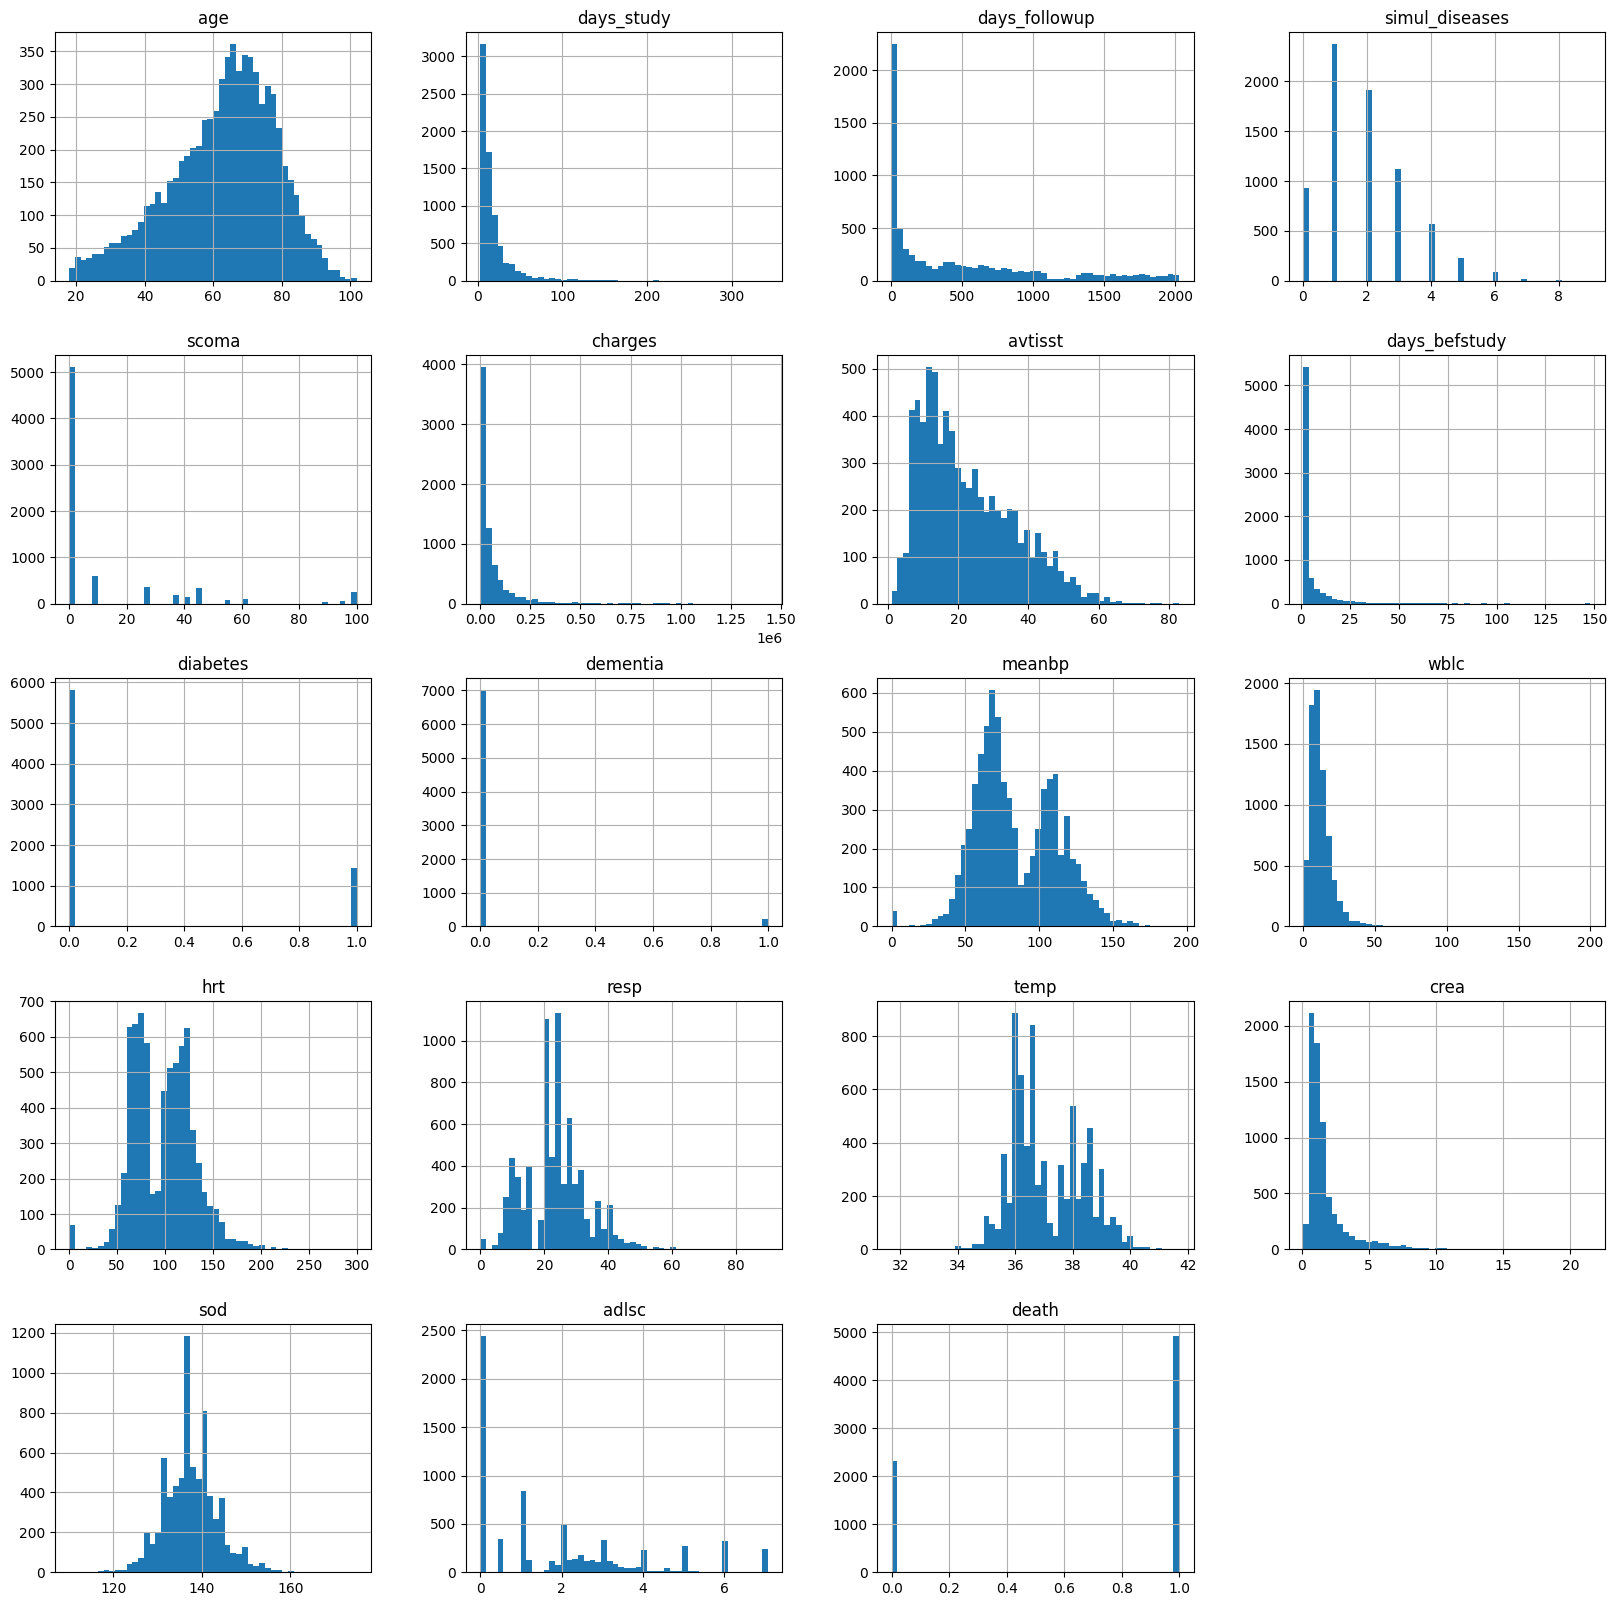

In [26]:
support.hist(bins=50, figsize=(20, 20))
plt.show()

We can clearly see that most likely, the days, charges, wblc and crea are going to have outliers. We'll inspect all the continious variables and perform a probability inspection to determine the relation between these extreme observations and the death of the patient and take the appropiate action from there.

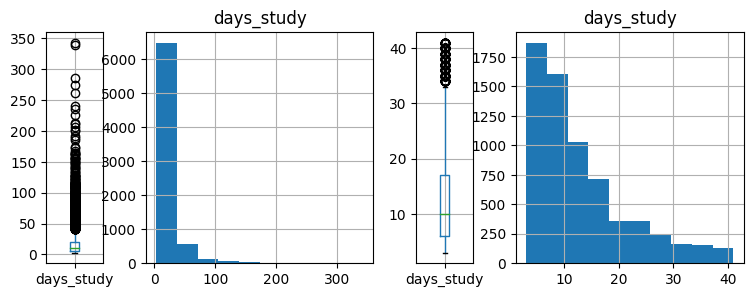

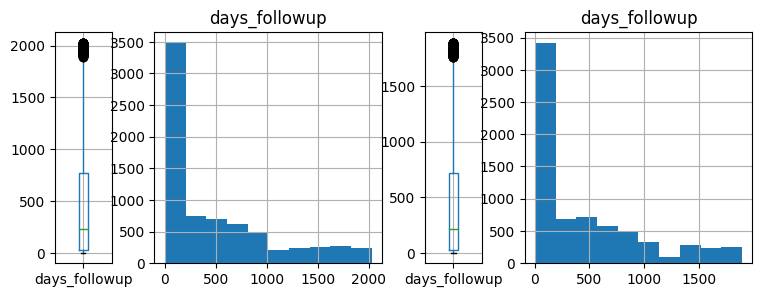

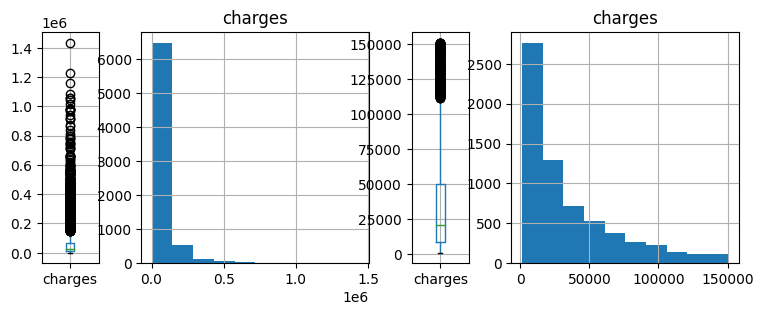

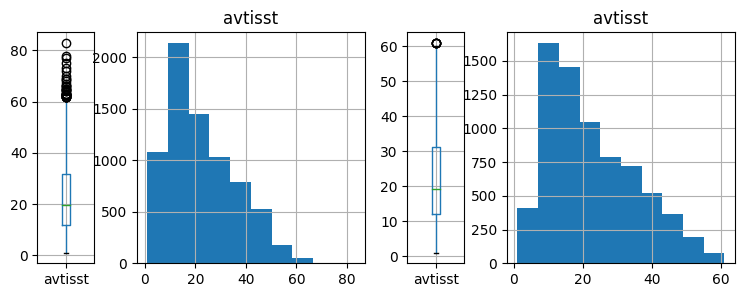

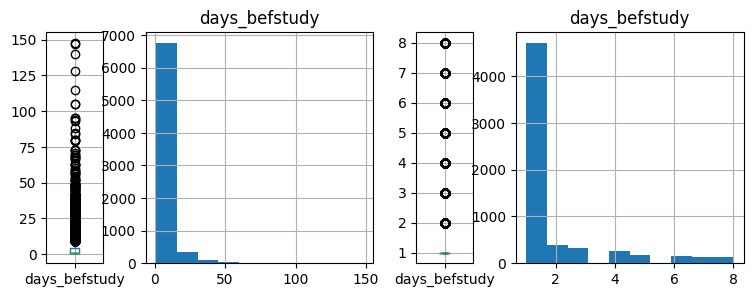

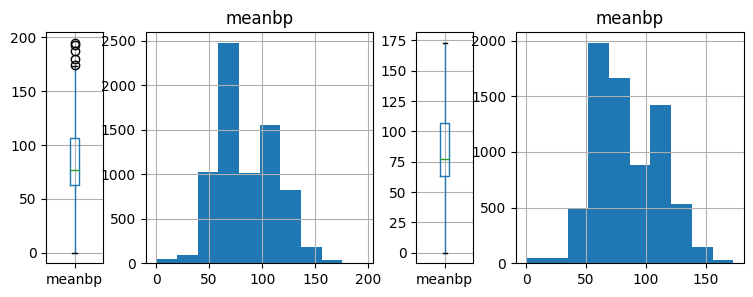

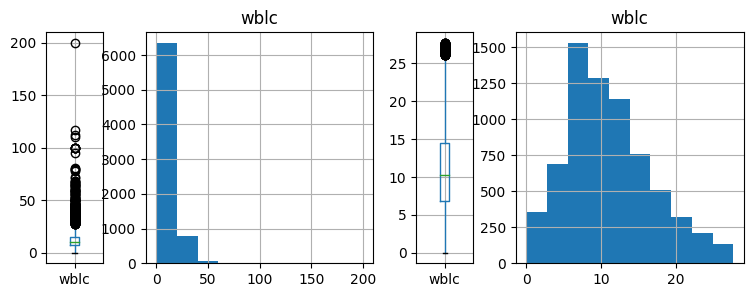

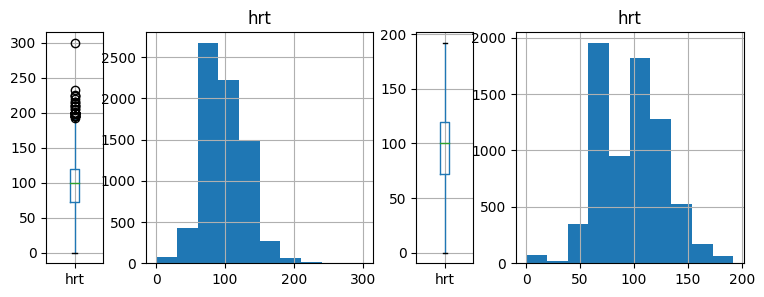

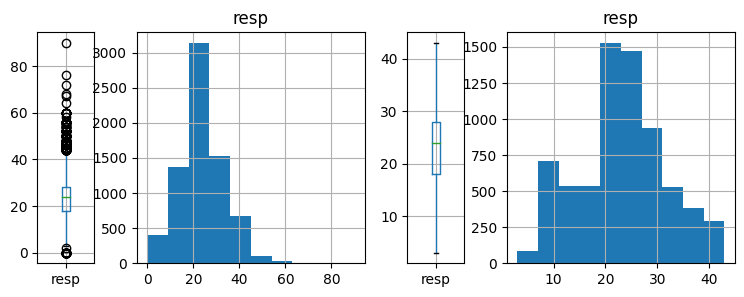

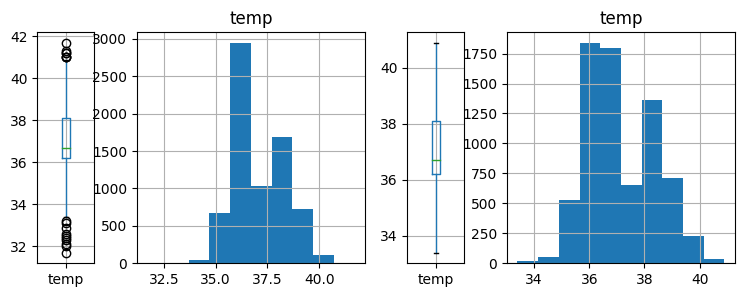

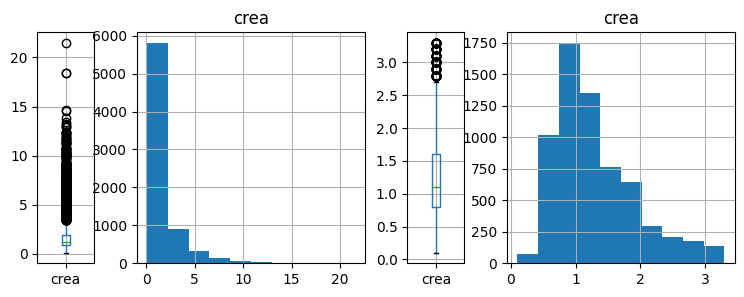

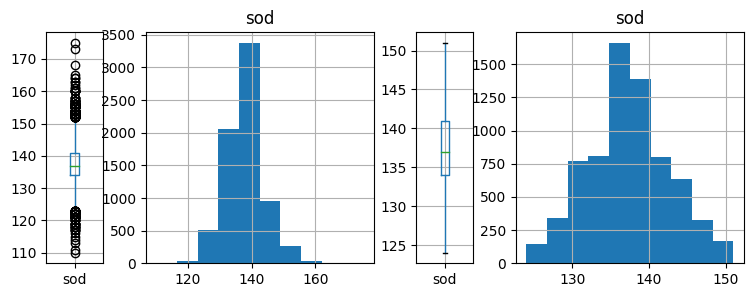

In [27]:
has_outliers = ["days_study", "days_followup", "charges", "avtisst", "days_befstudy", "meanbp", "wblc", "hrt", "resp", "temp", "crea", "sod"]

for col in has_outliers:
    Q1 = support[col].quantile(0.25)
    Q3 = support[col].quantile(0.75)
    IQR = Q3 - Q1

    small_outliers = support[col] < (Q1 - 1.5 * IQR)
    big_outliers = support[col] > (Q3 + 1.5 * IQR)

    fig, axes= plt.subplots(1,4, gridspec_kw={'width_ratios': [1, 4, 1, 4]}, figsize=(9,3))
    
    support.boxplot(column=col,ax=axes[0]);
    support.hist(column=col, ax=axes[1]);

    support[~(small_outliers | big_outliers)].boxplot(column=col,ax=axes[2]);
    support[~(small_outliers | big_outliers)].hist(column=col, ax=axes[3]);
    plt.show()

In [28]:
has_significant_outliers = ["days_study", "charges", "avtisst", "days_befstudy", "meanbp", "wblc", "hrt", "resp", "crea", "sod"]

for col in has_significant_outliers:
    Q1 = support[col].quantile(0.25)
    Q3 = support[col].quantile(0.75)
    IQR = Q3 - Q1

    small_outliers = support[col] < (Q1 - 1.5 * IQR)
    big_outliers = support[col] > (Q3 + 1.5 * IQR)

    support[col] = support[col][~(small_outliers | big_outliers)]

support.dropna(inplace=True)

In [29]:
support.shape

(4644, 24)

In [30]:
support.isnull().sum()

age               0
sex               0
days_study        0
days_followup     0
dzgroup           0
dzclass           0
simul_diseases    0
scoma             0
charges           0
avtisst           0
race              0
days_befstudy     0
diabetes          0
dementia          0
ca                0
meanbp            0
wblc              0
hrt               0
resp              0
temp              0
crea              0
sod               0
adlsc             0
death             0
dtype: int64

### 2.4. Gaussianity and transformations


We observe the histograms and boxplots of the data treated.  

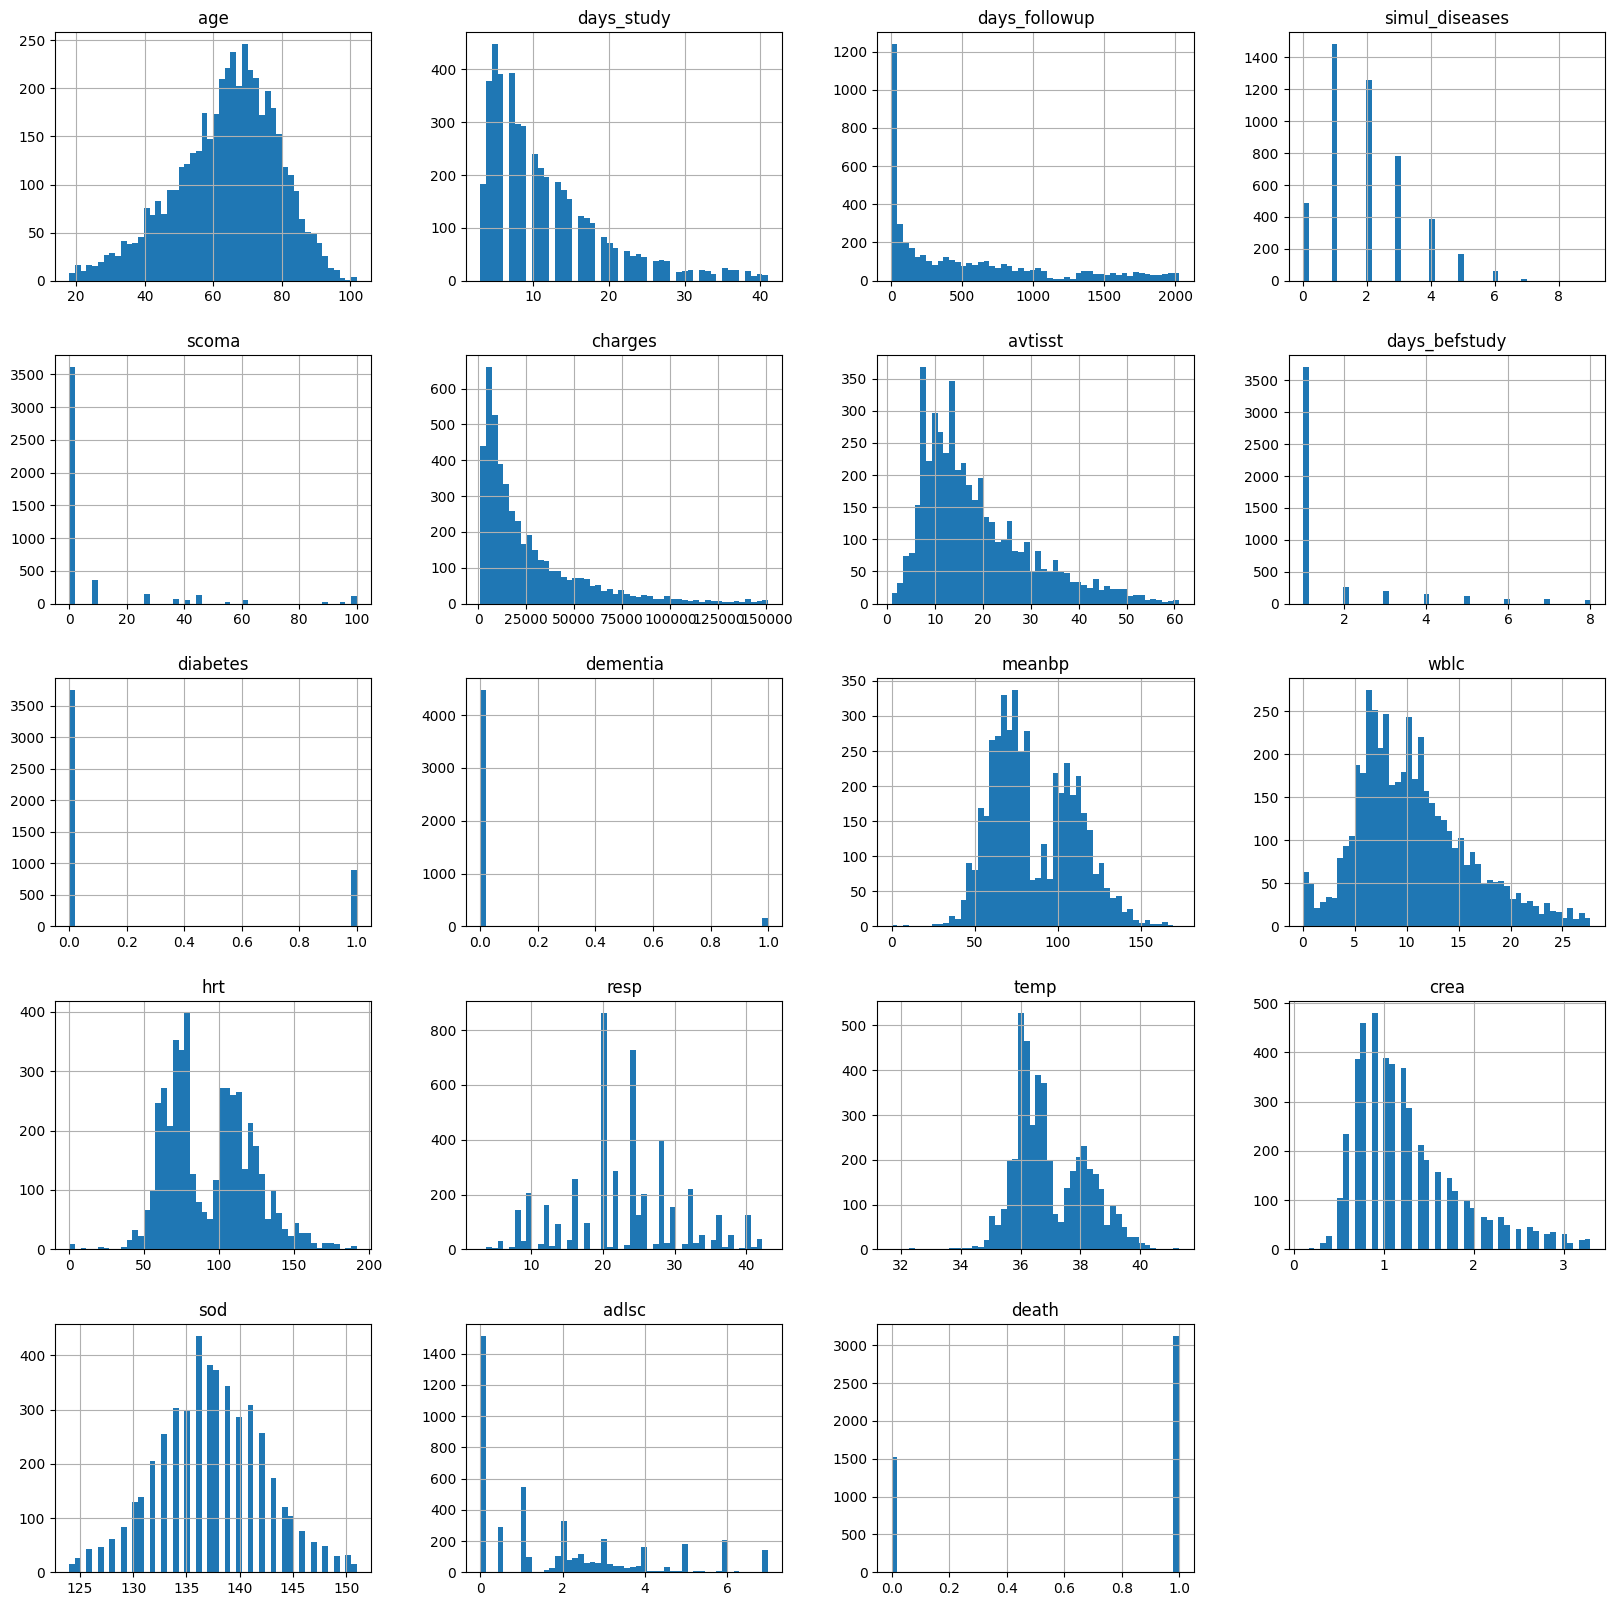

In [31]:
support.hist(bins=50,figsize=(20, 20))
plt.show()

We can see that most of them follow a normal distribution. 

For the categories that don't obey a gaussian distribution we consider making a transformation of the data. 

<Axes: >

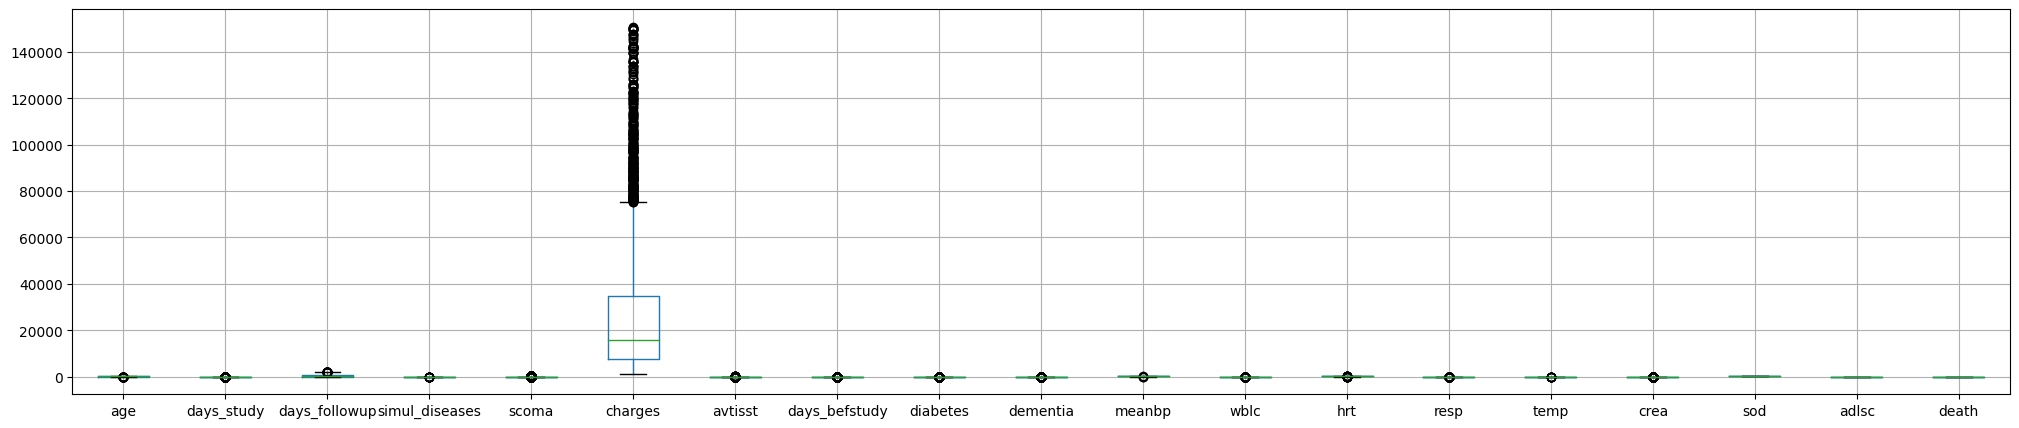

In [32]:
support.boxplot(figsize=(25, 5))

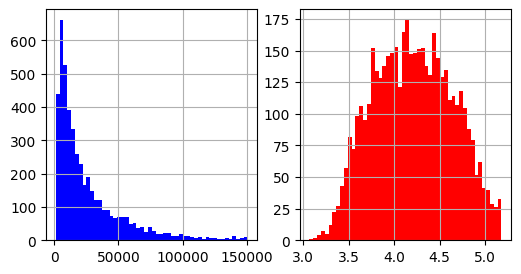

In [33]:
support_log_charges = support.copy()
fig, axes= plt.subplots(1,2 )
support.charges.hist(bins=50,figsize=(6,3), color='blue', ax=axes[0])
support_log_charges.charges.apply(np.log10).hist(bins=50,figsize=(6,3), color='red', ax=axes[1]);

<Axes: >

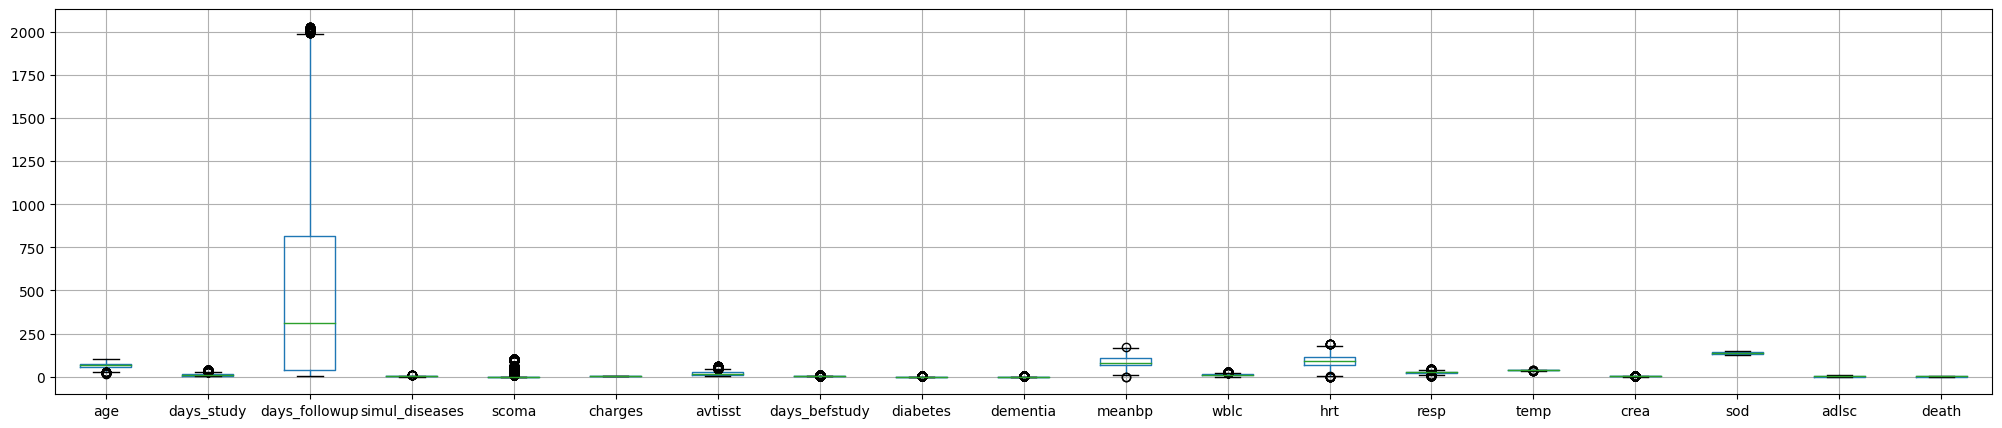

In [34]:
support['charges'] = np.log10(support['charges'])
support.boxplot(figsize=(25, 5))

In [35]:
support = support_log_charges.copy()

### 2.5 Feature encoding




After performing the feature selection the observed categories don't follow any ordinal relation, and we still have a reasonable amount of features to work with, we'll perform One Hot encoding. This way, we ensure maintaining the relations between the categories at the expense of increasing the dimentionality.

In [36]:
X_train = support.drop("death", axis=1)
y_train = support["death"]

X_train = pd.get_dummies(X_train, columns=numeral)
X_test = pd.get_dummies(X_test, columns=numeral)

In [37]:
y_train.replace(['no', 'yes'], [0,1], inplace=True)
X_train["ca"].replace(['no', 'yes','metastatic'], [0, 1, 2], inplace=True)

y_test.replace(['no', 'yes'], [0,1], inplace=True)
X_test["ca"].replace(['no', 'yes','metastatic'], [0, 1, 2], inplace=True)

In [38]:
X_train.describe()

,age,days_study,days_followup,simul_diseases,scoma,charges,avtisst,days_befstudy,ca,meanbp,wblc,hrt,resp,temp,crea,sod,adlsc
count,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000,4644.000000
mean,63.846554,11.678295,520.812661,1.981266,8.593023,25994.257246,18.617911,1.602713,0.620155,85.684970,10.531805,93.689362,22.858096,36.996444,1.261190,137.322567,1.868923
std,14.922254,7.826260,571.381422,1.362506,21.657203,26900.131677,11.242701,1.464344,0.859999,25.152356,5.338799,28.173132,7.898526,1.182999,0.593094,4.988308,1.978942
min,18.041990,3.000000,3.000000,0.000000,0.000000,1169.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,31.699220,0.099991,124.000000,0.000000
25%,54.625235,6.000000,36.000000,1.000000,0.000000,7430.136750,10.250000,1.000000,0.000000,67.000000,6.699219,70.000000,20.000000,36.093750,0.799927,134.000000,0.000000
50%,65.523465,9.000000,310.000000,2.000000,0.000000,15858.500000,15.500000,1.000000,0.000000,80.000000,9.798828,92.000000,24.000000,36.593750,1.099854,137.000000,1.000000
75%,74.541455,15.000000,817.000000,3.000000,0.000000,34592.000000,24.500000,1.000000,2.000000,107.000000,13.500000,115.000000,28.000000,38.000000,1.500000,141.000000,3.000000
max,101.847960,41.000000,2029.000000,9.000000,100.000000,150904.000000,61.000000,8.000000,2.000000,173.000000,27.699219,192.000000,43.000000,41.296880,3.299805,151.000000,7.000000


In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4644 entries, 6892 to 2343
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         4644 non-null   float64
 1   days_study                  4644 non-null   float64
 2   days_followup               4644 non-null   int64  
 3   simul_diseases              4644 non-null   int64  
 4   scoma                       4644 non-null   float64
 5   charges                     4644 non-null   float64
 6   avtisst                     4644 non-null   float64
 7   days_befstudy               4644 non-null   float64
 8   ca                          4644 non-null   int64  
 9   meanbp                      4644 non-null   float64
 10  wblc                        4644 non-null   float64
 11  hrt                         4644 non-null   float64
 12  resp                        4644 non-null   float64
 13  temp                        4644 no

In [40]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1811 entries, 4628 to 5697
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         1811 non-null   float64
 1   days_study                  1811 non-null   int64  
 2   days_followup               1811 non-null   int64  
 3   simul_diseases              1811 non-null   int64  
 4   scoma                       1811 non-null   float64
 5   charges                     1811 non-null   float64
 6   avtisst                     1811 non-null   float64
 7   days_befstudy               1811 non-null   int64  
 8   ca                          1811 non-null   int64  
 9   meanbp                      1811 non-null   float64
 10  wblc                        1811 non-null   float64
 11  hrt                         1811 non-null   float64
 12  resp                        1811 non-null   float64
 13  temp                        1811 no

### 2.6 Normalization

To avoid that some features adquire more importance for its high values we normalize or standarize your data. In this way we force to have the same range for each variable. 

We use the min-max scaling, that send our data to the range [0,1].

In [41]:
min_max_scaler =  MinMaxScaler()
X_train[numerical_features] = min_max_scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = min_max_scaler.transform(X_test[numerical_features])

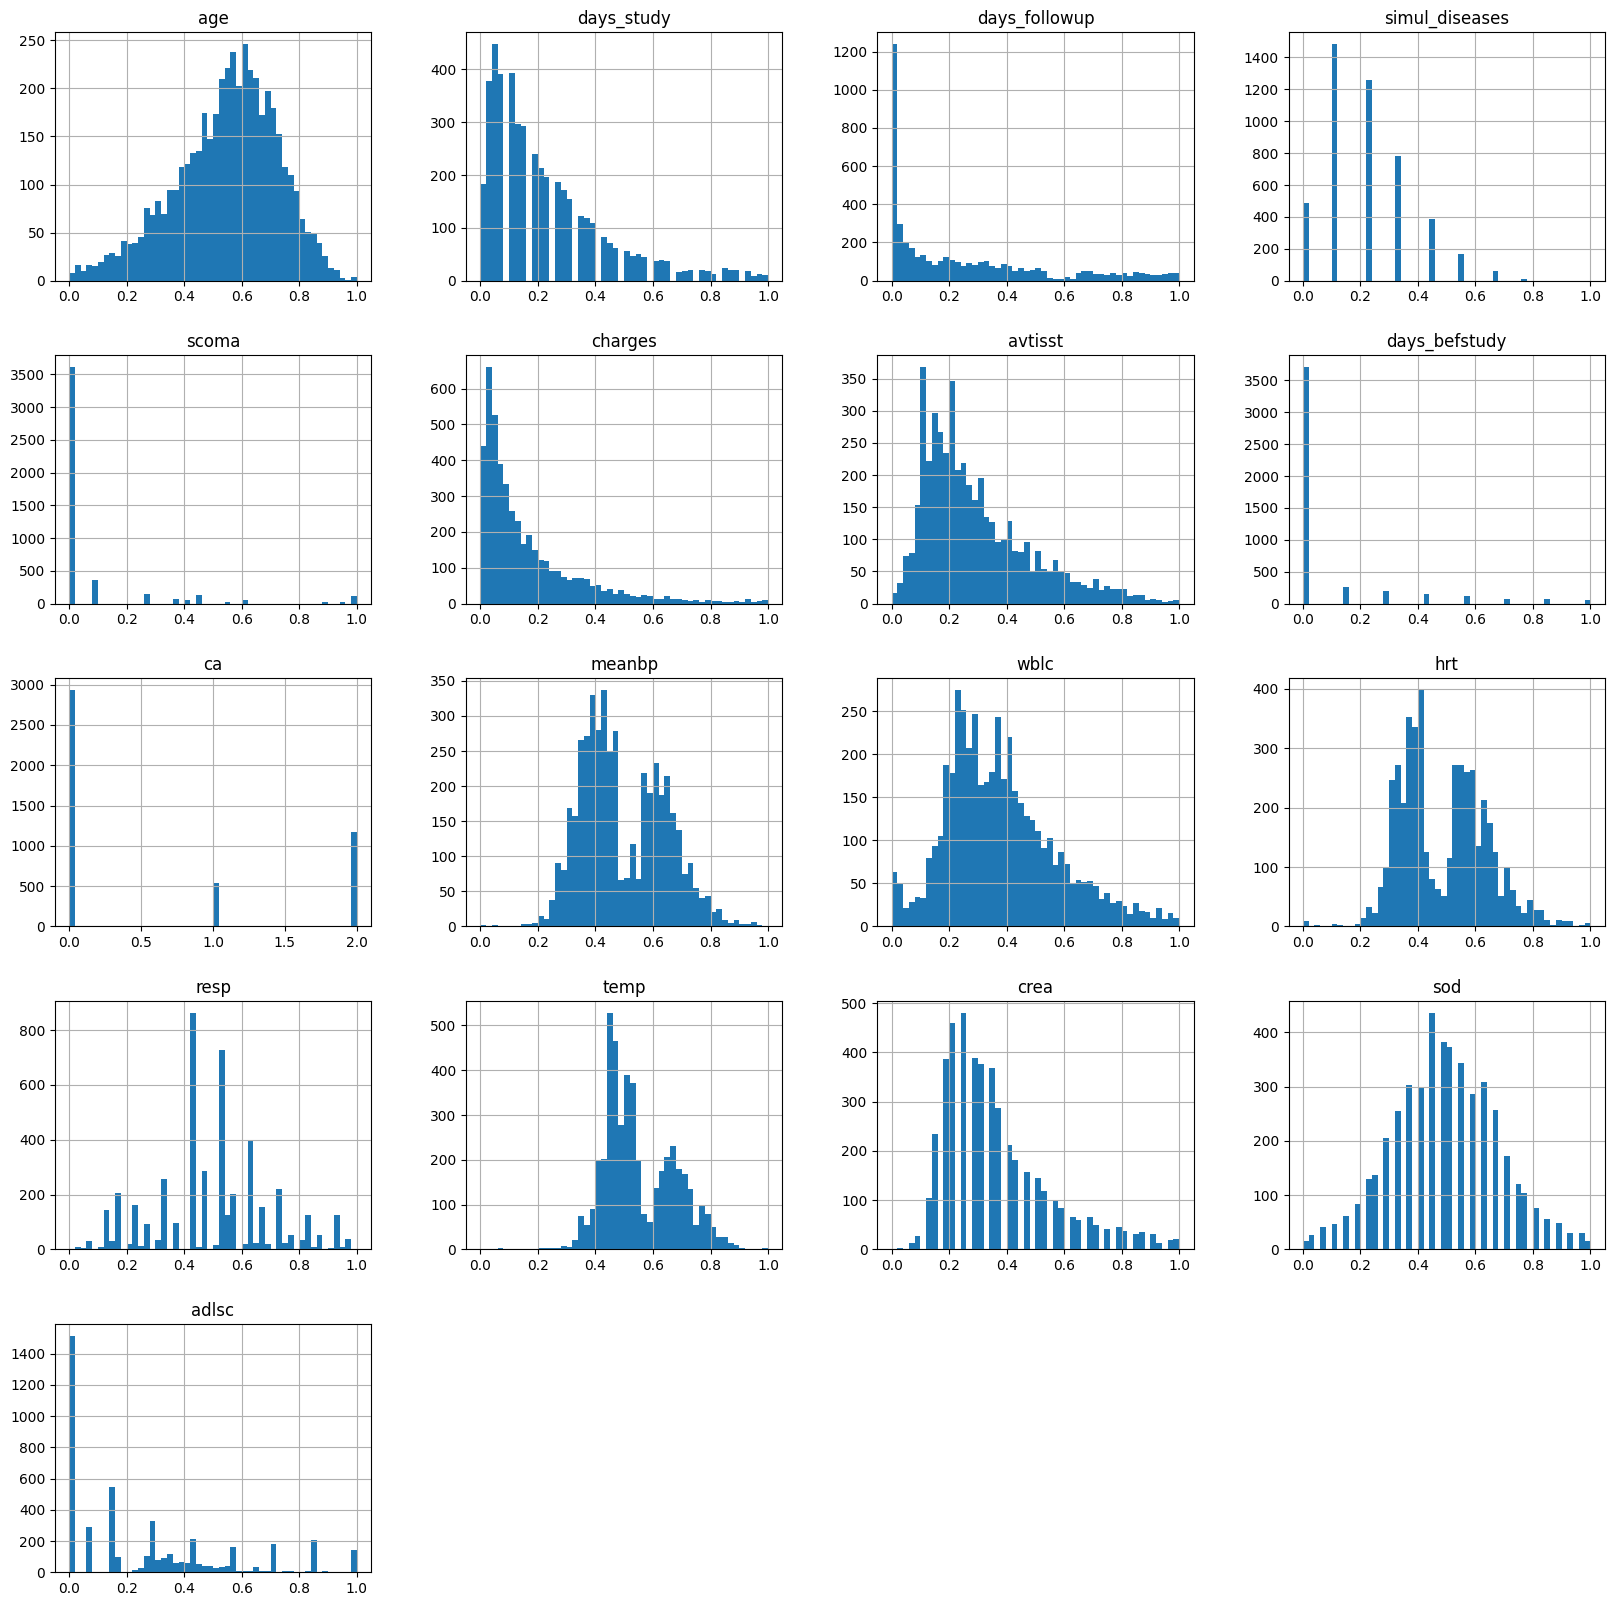

In [42]:
X_train.hist(bins=50,figsize=(20, 20))
plt.show()

## 3. Modeling

### 3.1 Utilities

In [43]:
# SCORING
beta = 2
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

In [44]:
def plot_metrics(name, model, X, y):

    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss']
    scores = dict()
    
    fbeta_scores = cross_val_score(model, X, y, cv=5, scoring=fbeta_scorer)

    for score in scoring:
        scores[score] = cross_val_score(model, X, y, cv=5, scoring=score)

    
    accuracy = np.mean(scores['accuracy'])
    precision = np.mean(scores['precision'])
    recall = np.mean(scores['recall'])
    f1 = np.mean(scores['f1'])
    fbeta = np.mean(fbeta_scores)
    roc_auc = np.mean(scores['roc_auc'])
    logloss = -np.mean(scores['neg_log_loss'])

    y_real = y
    y_pred = model.predict(X)
    cm = confusion_matrix(y_real, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Dead', 'Alive'], yticklabels=['Dead', 'Alive'])
    plt.xlabel('Predicted outcome')
    plt.ylabel('True outcome')
    plt.title('Confusion Matrix')
    plt.show()
    
    metrics = pd.DataFrame({
    'Model' : [name],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'F-beta Score': [fbeta],
    'ROC-AUC': [roc_auc],
    'Log Loss': [logloss]
    })

    return metrics

def confusion(true, pred):
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

models = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F-beta Score', 'ROC-AUC', 'Log Loss'])

### 3.2 Logistic Regression

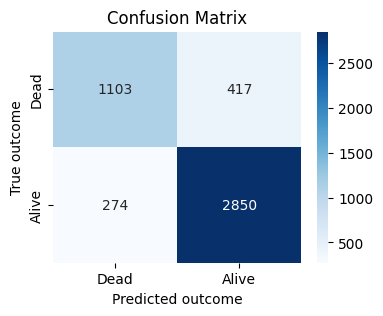

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932


In [45]:
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV

logreg = LogisticRegressionCV(Cs=20, random_state=1, cv = 10, scoring = 'precision', penalty="l2")
logreg.fit(X_train, y_train.values.ravel())
avg_crossval_scores = logreg.scores_[1].mean(axis=0)
best_C = logreg.Cs_[np.argmax(avg_crossval_scores)]

logreg = LogisticRegression(C=best_C, penalty="l2")
logreg.fit(X_train, y_train.values.ravel())

models = pd.concat([models, plot_metrics("Logistic Regression", logreg, X_train, y_train)])
models.head()


### 3.3 KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(
    estimator=knn,
    param_grid={
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20],
        'metric': ['cityblock', 'cosine', 'l1', 'l2', 'euclidean', 'minkowski', 'manhattan']
    },
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    refit=False
)

knn_cv.fit(X_train, y_train.values.ravel())
results_cv = pd.DataFrame(knn_cv.cv_results_)

In [47]:
cols = ['param_n_neighbors', 'param_metric',
     'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro', 
    'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro',
    'std_test_recall_macro'
]
results_cv[cols].sort_values(by='mean_test_f1_macro',ascending=False)

,param_n_neighbors,param_metric,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro
48,20,manhattan,0.808573,0.771321,0.791136,0.760094,0.013121,0.016546,0.016396,0.016755
6,20,cityblock,0.808573,0.771321,0.791136,0.760094,0.013121,0.016546,0.016396,0.016755
20,20,l1,0.808573,0.771321,0.791136,0.760094,0.013121,0.016546,0.016396,0.016755
11,10,cosine,0.803403,0.771279,0.779456,0.765203,0.008922,0.009270,0.011515,0.008113
46,10,manhattan,0.803404,0.771021,0.779842,0.764697,0.009932,0.009946,0.013222,0.008486
4,10,cityblock,0.803404,0.771021,0.779842,0.764697,0.009932,0.009946,0.013222,0.008486
18,10,l1,0.803404,0.771021,0.779842,0.764697,0.009932,0.009946,0.013222,0.008486
16,5,l1,0.803833,0.767028,0.783522,0.756910,0.007629,0.009530,0.009388,0.009695
2,5,cityblock,0.803833,0.767028,0.783522,0.756910,0.007629,0.009530,0.009388,0.009695
44,5,manhattan,0.803833,0.767028,0.783522,0.756910,0.007629,0.009530,0.009388,0.009695


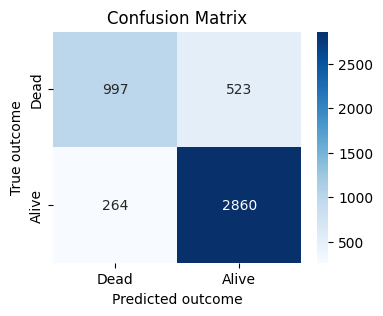

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365


In [48]:
knn = KNeighborsClassifier(n_neighbors=20, metric='manhattan')
knn.fit(X_train, y_train.values.ravel())

models = pd.concat([models, plot_metrics("KNN", knn, X_train, y_train)])
models.head()

### 3.4 Discriminant Analysis

/home/biel/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


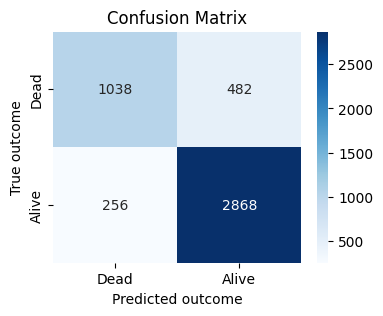

/home/biel/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/biel/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/biel/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/biel/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/biel/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/biel/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/biel/.loca

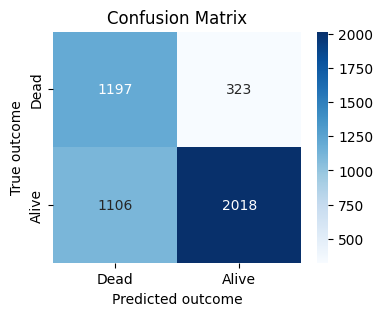

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,LDA,0.838286,0.854327,0.916133,0.884044,0.902994,0.932521,0.349181
0,QDA,0.700482,0.848630,0.676726,0.751231,0.704370,0.794206,2.901450


In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train.values.ravel())
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train.values.ravel())
models = pd.concat([models, plot_metrics("LDA", lda, X_train, y_train)])
models = pd.concat([models, plot_metrics("QDA", qda, X_train, y_train)])
models.head()

### 3.5 SVM

In [50]:
from sklearn.svm import SVC
svc = SVC()
svc_cv = GridSearchCV(estimator=svc, param_grid={
    'C': [0.1, 1, 10, 100],
    'gamma': ["auto", "scale", 1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', "poly"]
    })

svc_cv.fit(X_train, y_train.values.ravel())
pd.DataFrame(knn_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_precision_macro,rank_test_precision_macro,split0_test_recall_macro,split1_test_recall_macro,split2_test_recall_macro,split3_test_recall_macro,split4_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro
0,0.003941,0.001548,0.052906,0.001625,cityblock,1,"{'metric': 'cityblock', 'n_neighbors': 1}",0.772874,0.780409,0.769645,...,0.005921,47,0.738279,0.742189,0.727432,0.733345,0.724106,0.733070,0.006671,47
1,0.003429,0.000395,0.053512,0.001127,cityblock,3,"{'metric': 'cityblock', 'n_neighbors': 3}",0.786868,0.795479,0.797632,...,0.005964,36,0.744455,0.750855,0.747387,0.752500,0.754850,0.750009,0.003690,22
2,0.003368,0.000265,0.049494,0.003714,cityblock,5,"{'metric': 'cityblock', 'n_neighbors': 5}",0.808396,0.790097,0.812702,...,0.009388,22,0.766368,0.740942,0.766189,0.759745,0.751307,0.756910,0.009695,11
3,0.003772,0.000304,0.055931,0.009953,cityblock,7,"{'metric': 'cityblock', 'n_neighbors': 7}",0.806243,0.797632,0.810549,...,0.008009,8,0.759700,0.746542,0.764589,0.754408,0.741312,0.753310,0.008474,18
4,0.004550,0.002154,0.058940,0.004642,cityblock,10,"{'metric': 'cityblock', 'n_neighbors': 10}",0.790097,0.794403,0.804090,...,0.013222,25,0.756147,0.754279,0.766547,0.769479,0.777033,0.764697,0.008486,2
5,0.003277,0.000139,0.057097,0.001163,cityblock,15,"{'metric': 'cityblock', 'n_neighbors': 15}",0.792250,0.799785,0.814855,...,0.011179,4,0.738318,0.744763,0.761032,0.740361,0.751139,0.747122,0.008227,32
6,0.003138,0.000092,0.058163,0.000700,cityblock,20,"{'metric': 'cityblock', 'n_neighbors': 20}",0.808396,0.790097,0.825619,...,0.016396,1,0.766368,0.743476,0.779168,0.737205,0.774249,0.760094,0.016755,5
7,0.005456,0.001001,0.153449,0.009180,cosine,1,"{'metric': 'cosine', 'n_neighbors': 1}",0.784715,0.771798,0.775027,...,0.005253,43,0.748768,0.729032,0.733121,0.736455,0.736463,0.736768,0.006593,39
8,0.006498,0.000866,0.197164,0.009500,cosine,3,"{'metric': 'cosine', 'n_neighbors': 3}",0.778256,0.789020,0.795479,...,0.009994,39,0.730453,0.746055,0.750855,0.722274,0.733637,0.736655,0.010435,40
9,0.006395,0.001246,0.205727,0.003814,cosine,5,"{'metric': 'cosine', 'n_neighbors': 5}",0.795479,0.795479,0.808396,...,0.006907,29,0.746632,0.751700,0.762989,0.748942,0.745741,0.751201,0.006245,21


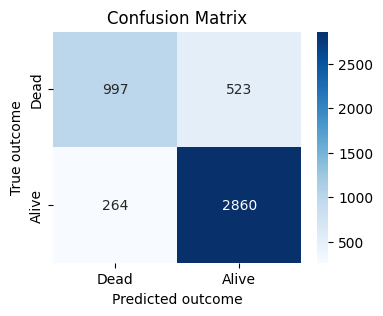

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,LDA,0.838286,0.854327,0.916133,0.884044,0.902994,0.932521,0.349181
0,QDA,0.700482,0.848630,0.676726,0.751231,0.704370,0.794206,2.901450
0,SVM,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365


In [51]:
svc = SVC(C=100, gamma=0.01, kernel='rbf')
svc.fit(X_train, y_train.values.ravel())
models = pd.concat([models, plot_metrics("SVM", knn, X_train, y_train)])
models.head()

### 3.6 Gaussian Naive Bayes

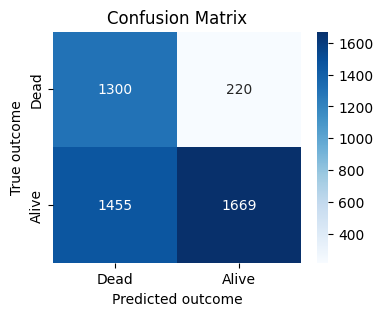

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,LDA,0.838286,0.854327,0.916133,0.884044,0.902994,0.932521,0.349181
0,QDA,0.700482,0.848630,0.676726,0.751231,0.704370,0.794206,2.901450
0,SVM,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,Gaussian Naive Bayes,0.637814,0.882662,0.532335,0.664076,0.578212,0.842532,1.871467


In [52]:
from sklearn.naive_bayes import GaussianNB
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train,y_train.values.ravel())
models = pd.concat([models, plot_metrics("Gaussian Naive Bayes", gaussian_nb, X_train, y_train)])
models

### 3.7 Stochastic Gradient Descent Classifier

In [53]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(random_state=42)
sgdc_cv = GridSearchCV(estimator=sgdc, param_grid={
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'shuffle': [True, False],
    'fit_intercept': [True, False],
    }
)

sgdc_cv.fit(X_train, y_train.values.ravel())
print(sgdc_cv.best_params_)

/home/biel/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/biel/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/biel/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/biel/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/biel/.local/lib/python3.8/site-packages/sk

{'fit_intercept': False, 'loss': 'hinge', 'penalty': 'l1', 'shuffle': True}


/home/biel/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/biel/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/home/biel/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    y_pred = method_caller(clf, "predict_proba", X, pos_label=self._get_pos_label())
  File "/home/biel/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/home/biel/.local/lib/python3.8/site-packages/sklearn/utils/_response.py", line 181, in _get_response_values
    prediction_method = _check_response_method(estimator, response_method)
  File "/home/biel/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1939, in 

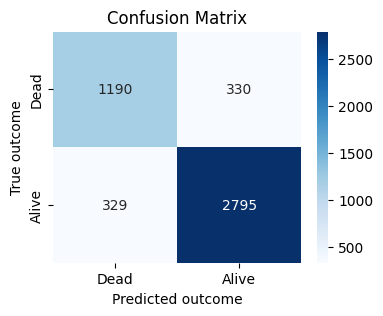

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,LDA,0.838286,0.854327,0.916133,0.884044,0.902994,0.932521,0.349181
0,QDA,0.700482,0.848630,0.676726,0.751231,0.704370,0.794206,2.901450
0,SVM,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,Gaussian Naive Bayes,0.637814,0.882662,0.532335,0.664076,0.578212,0.842532,1.871467
0,SGDC,0.852498,0.910678,0.866843,0.887516,0.874837,0.925462,NaN


In [54]:
sgdc = SGDClassifier(random_state=42, fit_intercept=False, loss='hinge', penalty='l1', shuffle=True)
sgdc.fit(X_train, y_train.values.ravel())
models = pd.concat([models, plot_metrics("SGDC", sgdc, X_train, y_train)])
models

### 3.8 Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(estimator=tree, param_grid= {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    },
   cv=5
)

tree_cv.fit(X_train, y_train.values.ravel())
print(tree_cv.best_params_)

{'criterion': 'log_loss', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


/home/biel/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
810 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/home/biel/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/biel/.local/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/biel/.local/lib/python3.8/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/biel/.local/lib/pytho

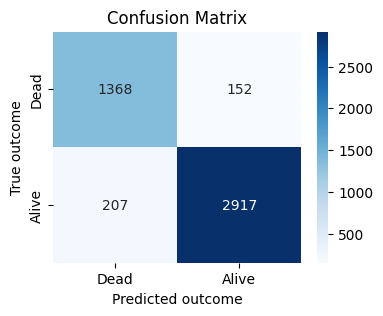

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,LDA,0.838286,0.854327,0.916133,0.884044,0.902994,0.932521,0.349181
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,Decision Tree,0.859823,0.902543,0.887648,0.894973,0.890549,0.915223,1.814702
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,SVM,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,SGDC,0.852498,0.910678,0.866843,0.887516,0.874837,0.925462,NaN
0,QDA,0.700482,0.848630,0.676726,0.751231,0.704370,0.794206,2.901450
0,Gaussian Naive Bayes,0.637814,0.882662,0.532335,0.664076,0.578212,0.842532,1.871467


In [56]:
tree = DecisionTreeClassifier(random_state=42, criterion='log_loss', max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10) 
tree.fit(X_train, y_train.values.ravel())
models = pd.concat([models, plot_metrics("Decision Tree", tree, X_train, y_train)])
models.sort_values(by="F-beta Score", ascending=False)

### 3.9 Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest_cv = GridSearchCV(estimator=forest, param_grid= {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
},
   cv=5
)

forest_cv.fit(X_train, y_train.values.ravel())
print(forest_cv.best_params_)


{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


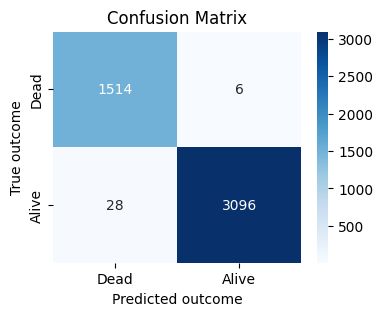

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,LDA,0.838286,0.854327,0.916133,0.884044,0.902994,0.932521,0.349181
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,Decision Tree,0.859823,0.902543,0.887648,0.894973,0.890549,0.915223,1.814702
0,Random Forest,0.875971,0.932049,0.879960,0.905166,0.889852,0.947727,0.277282
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,SVM,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,SGDC,0.852498,0.910678,0.866843,0.887516,0.874837,0.925462,NaN
0,QDA,0.700482,0.848630,0.676726,0.751231,0.704370,0.794206,2.901450
0,Gaussian Naive Bayes,0.637814,0.882662,0.532335,0.664076,0.578212,0.842532,1.871467


In [58]:
forest = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=42) 
forest.fit(X_train, y_train.values.ravel())
models = pd.concat([models, plot_metrics("Random Forest", forest, X_train, y_train)])
models.sort_values(by="F-beta Score", ascending=False)

### 3.10 AdaBoost

In [59]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier()

adb_cv = GridSearchCV(estimator=adb, param_grid={
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0, 10.0]
},
   cv=5
)

adb_cv.fit(X_train, y_train.values.ravel())
print(adb_cv.best_params_)

{'learning_rate': 1.0, 'n_estimators': 200}


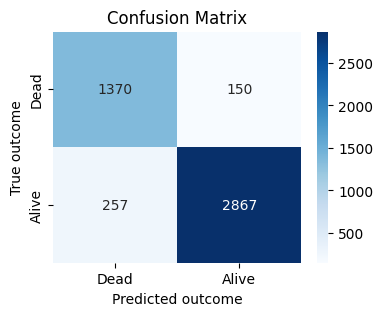

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,LDA,0.838286,0.854327,0.916133,0.884044,0.902994,0.932521,0.349181
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,AdaBoost,0.880922,0.924912,0.895965,0.910048,0.901508,0.952212,0.645760
0,Decision Tree,0.859823,0.902543,0.887648,0.894973,0.890549,0.915223,1.814702
0,Random Forest,0.875971,0.932049,0.879960,0.905166,0.889852,0.947727,0.277282
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,SVM,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,SGDC,0.852498,0.910678,0.866843,0.887516,0.874837,0.925462,NaN
0,QDA,0.700482,0.848630,0.676726,0.751231,0.704370,0.794206,2.901450
0,Gaussian Naive Bayes,0.637814,0.882662,0.532335,0.664076,0.578212,0.842532,1.871467


In [60]:
adb = AdaBoostClassifier(n_estimators=200, learning_rate=1, random_state=42)
adb.fit(X_train, y_train.values.ravel())
models = pd.concat([models, plot_metrics("AdaBoost", adb, X_train, y_train)])
models.sort_values(by="F-beta Score", ascending=False)

### 3.11 Gradient Boosting

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

gbc_cv = GridSearchCV(estimator=gbc, param_grid={
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
},
    cv=5
)

gbc_cv.fit(X_train, y_train.values.ravel())
print(gbc_cv.best_params_) 
 

{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


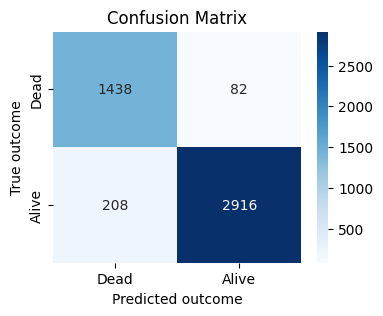

In [62]:
gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=42)
gbc.fit(X_train, y_train.values.ravel())
models = pd.concat([models, plot_metrics("Gradient Boosting", gbc, X_train, y_train)])

In [72]:
models.sort_values(by="F-beta Score", ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Gradient Boosting,0.893413,0.943646,0.895327,0.918620,0.904448,0.960342,0.227130
0,LDA,0.838286,0.854327,0.916133,0.884044,0.902994,0.932521,0.349181
0,Logistic Regression,0.847975,0.869517,0.911008,0.889658,0.902315,0.929282,0.331932
0,AdaBoost,0.880922,0.924912,0.895965,0.910048,0.901508,0.952212,0.645760
0,Decision Tree,0.859823,0.902543,0.887648,0.894973,0.890549,0.915223,1.814702
0,Random Forest,0.875971,0.932049,0.879960,0.905166,0.889852,0.947727,0.277282
0,KNN,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,SVM,0.808573,0.829724,0.900450,0.863540,0.885286,0.868093,0.485365
0,SGDC,0.852498,0.910678,0.866843,0.887516,0.874837,0.925462,NaN
0,QDA,0.700482,0.848630,0.676726,0.751231,0.704370,0.794206,2.901450


## 4. Testing

As we have a imbalanced dataset we need to consider this fact treating the dataset.  

In [63]:
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in the training set:", dict(zip(unique, counts)))

Class distribution in the training set: {0: 1520, 1: 3124}


### 4.1 Undersampling

First, we can consider we have a large number of rows we will randomly undersample the dataset

In [64]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data_death = train_data[train_data.death == 1]
train_data_death = train_data_death.sample(1520)

train_data_balanced = pd.concat([train_data_death, train_data[train_data.death == 0]])
X_train_balanced = train_data_balanced.drop("death", axis=1)
y_train_balanced = train_data_balanced["death"]

unique, counts = np.unique(y_train_balanced, return_counts=True)
print("Class distribution in the balanced training set:", dict(zip(unique, counts)))



Class distribution in the balanced training set: {0: 1520, 1: 1520}


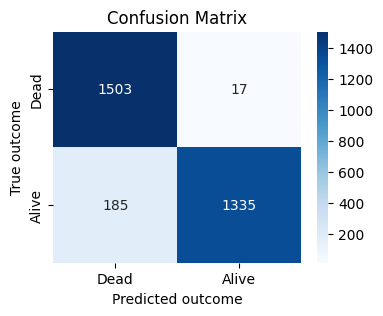

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Gradient Boosting,0.899671,0.961953,0.828947,0.890618,0.852384,0.955181,0.240518


In [65]:
gbc_under = GradientBoostingClassifier()
gbc_under.fit(X_train_balanced, y_train_balanced.values.ravel())
plot_metrics("Gradient Boosting", gbc_under, X_train_balanced, y_train_balanced)

### 4.2 Oversampling

We also try randomly oversampling the minority class. So to balance the classes we apply SMOTE 

In [66]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train.values)

unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
print("Class distribution in the training set after SMOTE:", dict(zip(unique_resampled, counts_resampled)))

Class distribution in the training set after SMOTE: {0: 3124, 1: 3124}


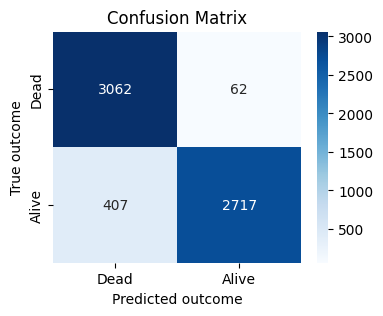

,Model,Accuracy,Precision,Recall,F1 Score,F-beta Score,ROC-AUC,Log Loss
0,Gradient Boosting,0.903175,0.959649,0.842518,0.896941,0.863437,0.963644,0.225639


In [67]:
gbc_over = GradientBoostingClassifier()
gbc_over.fit(X_train_resampled, y_train_resampled)
plot_metrics("Gradient Boosting", gbc_over, X_train_resampled, y_train_resampled)

### 4.4 Prediction

In [68]:
print(gbc_cv.best_params_)
y_test_pred = gbc.predict(X_test)

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test,y_test_pred))

{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
[[ 509   70]
 [ 109 1123]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       579
           1       0.94      0.91      0.93      1232

    accuracy                           0.90      1811
   macro avg       0.88      0.90      0.89      1811
weighted avg       0.90      0.90      0.90      1811



In [69]:
metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
for metric in metrics:
    print(metric, metric(y_test, y_test_pred))
    

<function accuracy_score at 0x7b5bd1ab7280> 0.9011595803423523
<function precision_score at 0x7b5bd18940d0> 0.9413243922883487
<function recall_score at 0x7b5bd18941f0> 0.911525974025974
<function f1_score at 0x7b5bd1ab7a60> 0.9261855670103093
<function roc_auc_score at 0x7b5bd189eee0> 0.8953139369266312


In [70]:
fbeta_score(y_test, y_test_pred, beta=2)

0.9173337689919949

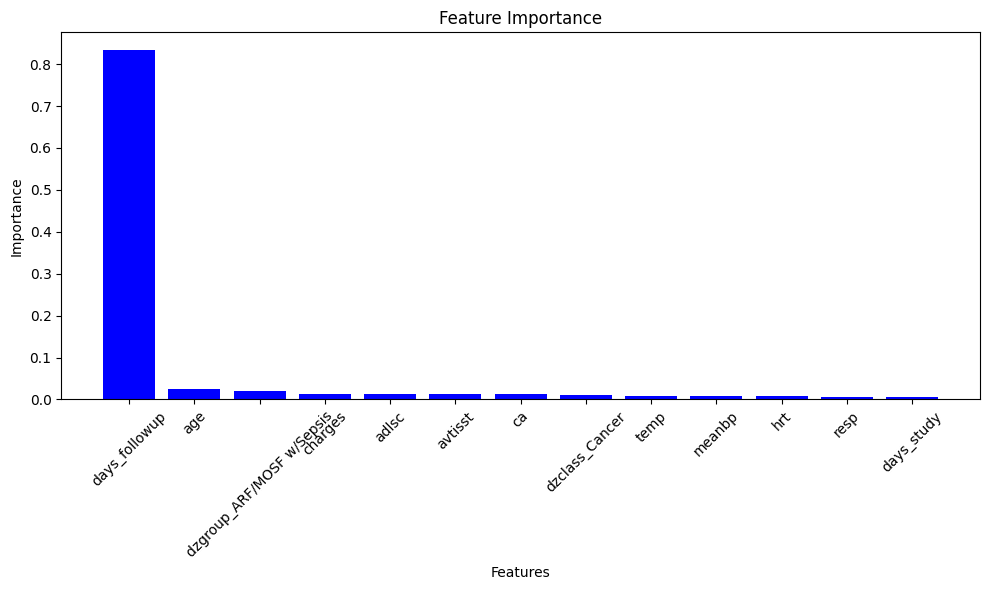

In [71]:

thereshold = 0.005

feature_importances = gbc.feature_importances_
feature_names = X_train.columns
selected_features = feature_names[feature_importances >= thereshold]
indices = np.argsort(feature_importances[feature_importances >= thereshold])[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(selected_features)), feature_importances[feature_importances >= thereshold][indices], color="b", align="center")
plt.xticks(range(len(selected_features)), np.array(selected_features)[indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()